In [1]:
import json
from collections import defaultdict
from datetime import datetime, timedelta

import backoff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import web3
from tqdm.notebook import tqdm
from web3.middleware import geth_poa_middleware

## Fetch data from last month

In [2]:
provider = web3.Web3.HTTPProvider('https://polygon-mainnet.g.alchemy.com/v2/06c36-lsZ0hXQ7xh_HzYEzNN3VffYTja')
w3 = web3.Web3(provider)
w3.middleware_onion.inject(geth_poa_middleware, layer=0)

In [3]:
interval = 2.2 # 2.2 seconds
hour_interval = int(60 * 60 / interval)

In [4]:
last_block = 41167883

In [5]:
with open('abi.json', 'r') as file:
    abi = file.read()

In [6]:
oracles = {
    'USDC': '0xfE4A8cc5b5B2366C1B58Bea3858e81843581b2F7',
    'ETH': '0xF9680D99D6C9589e2a93a78A04A279e509205945',
    'USDT': '0x0A6513e40db6EB1b165753AD52E80663aeA50545',
    'DAI': '0x4746DeC9e833A82EC7C2C1356372CcF2cfcD2F3D',
    'BTC': '0xc907E116054Ad103354f2D350FD2514433D57F6f',
    'stMATIC': '0x97371dF4492605486e23Da797fA68e55Fc38a13f',
    'wstETH': '0x10f964234cae09cB6a9854B56FF7D4F38Cda5E6a',
    'MATIC': '0xAB594600376Ec9fD91F8e885dADF0CE036862dE0',
}

In [16]:
@backoff.on_exception(
    backoff.constant,
    web3.exceptions.Any,
    max_tries=3,
)
def get_price(oracle_address: str, block: int):
    oracle = w3.eth.contract(
        address=oracle_address,
        abi=abi,
    )
    return oracle.functions.latestRoundData().call(block_identifier=block)[1]

In [27]:
prices = defaultdict(lambda: {})

with open('collected.json', 'r') as file:
    cached = json.load(file)

for i in tqdm(range(24 * 30)):
    block = last_block - i * hour_interval
    for token, oracle in oracles.items():
        cached_item = cached.get(str(block), {}).get(token)
        prev_item = prices.get(block, {}).get(token)
        prices[block][token] = cached_item or prev_item or get_price(oracle, block)

  0%|          | 0/720 [00:00<?, ?it/s]

In [28]:
with open('collected.json', 'w') as file:
    json.dump(prices, file)

## Extract distribution parameters

In [7]:
decimals = {}

for token, oracle in oracles.items():
    decimals[token] = w3.eth.contract(
        address=oracle,
        abi=abi,
    ).functions.decimals().call()

In [8]:
with open('collected.json', 'r') as file:
    prices = json.load(file)

In [9]:
blocks = list(sorted(int(x) for x in prices.keys()))
starting_ts = w3.eth.get_block('latest')
ts = [
    datetime.fromtimestamp(starting_ts.timestamp) + timedelta(seconds=int(interval * x - blocks[0]))
    for x in blocks
]

In [10]:
for block in blocks:
    tokens = prices[str(block)].keys()
    for token in tokens:
        prices[str(block)][token] /= 10 ** decimals[token]

In [11]:
for block in blocks:
    prices[str(block)]['wstETH'] *= prices[str(block)]['ETH']

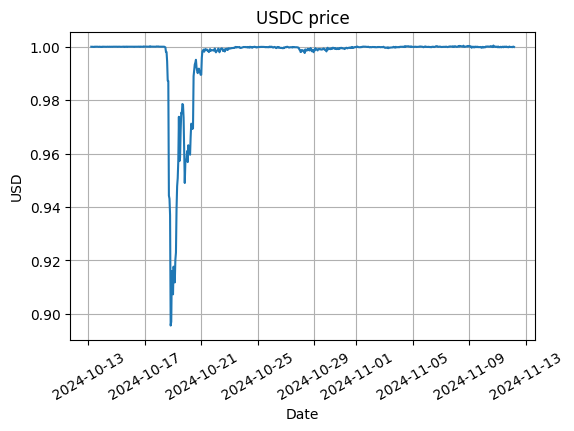

In [12]:
plt.figure(figsize=(6, 4))
plt.title('USDC price')
plt.plot(ts, [prices[str(x)]['USDC'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

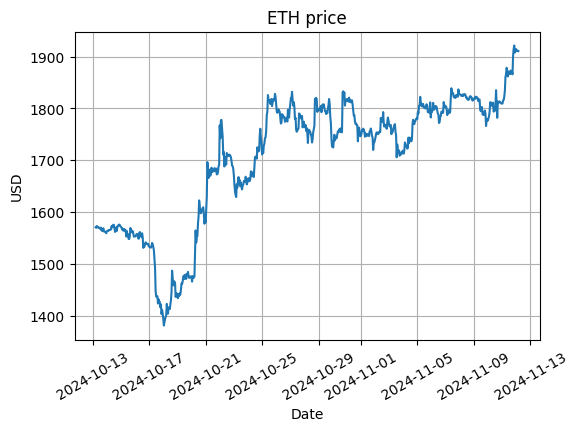

In [13]:
plt.figure(figsize=(6, 4))
plt.title('ETH price')
plt.plot(ts, [prices[str(x)]['ETH'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

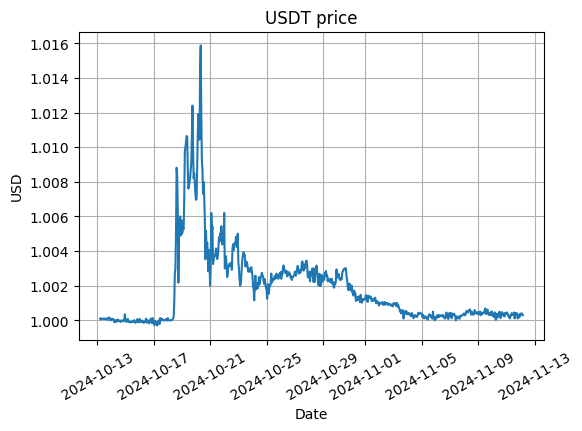

In [14]:
plt.figure(figsize=(6, 4))
plt.title('USDT price')
plt.plot(ts, [prices[str(x)]['USDT'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

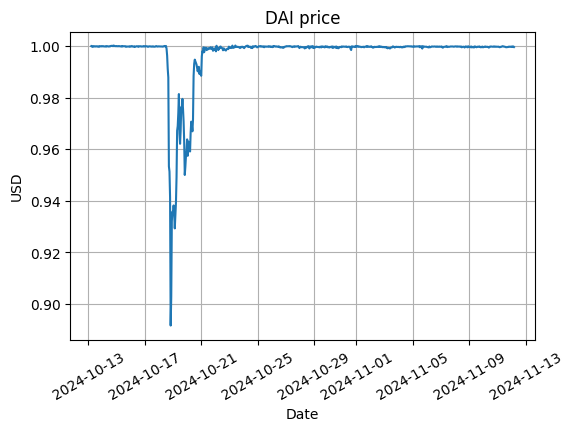

In [15]:
plt.figure(figsize=(6, 4))
plt.title('DAI price')
plt.plot(ts, [prices[str(x)]['DAI'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

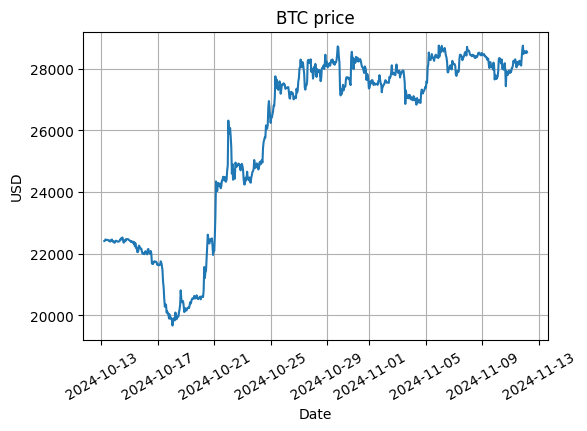

In [16]:
plt.figure(figsize=(6, 4))
plt.title('BTC price')
plt.plot(ts, [prices[str(x)]['BTC'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

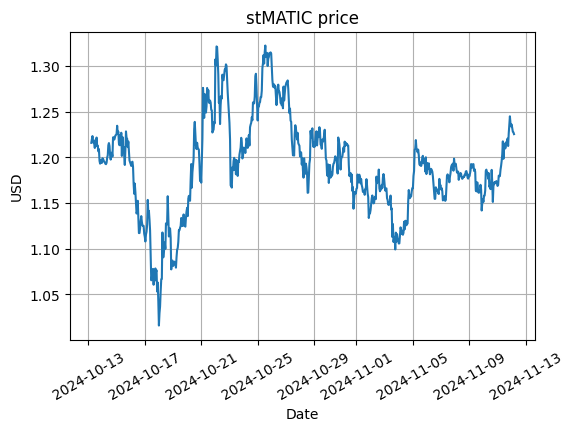

In [17]:
plt.figure(figsize=(6, 4))
plt.title('stMATIC price')
plt.plot(ts, [prices[str(x)]['stMATIC'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

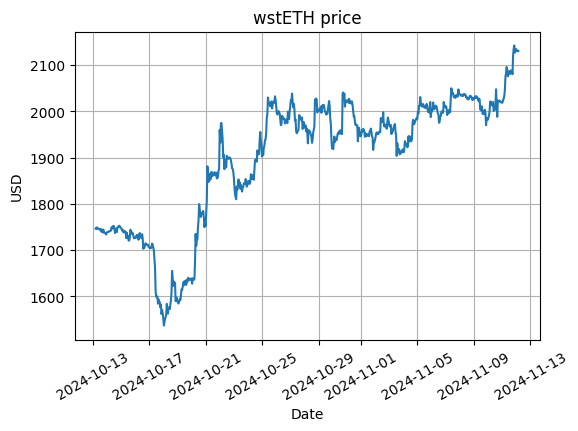

In [18]:
plt.figure(figsize=(6, 4))
plt.title('wstETH price')
plt.plot(ts, [prices[str(x)]['wstETH'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

In [41]:
prices_diff.shape

(7, 719)

In [19]:
tokens = prices[str(blocks[0])].keys()
prices_diff = np.vstack([np.diff(np.log([prices[str(block)][token] for block in blocks])) for token in tokens])

In [64]:
prices_diff.shape

(7, 719)

In [65]:
means = np.mean(prices_diff[:, 250:], axis=1)
covariations = np.cov(prices_diff[:, 250:])

<Axes: >

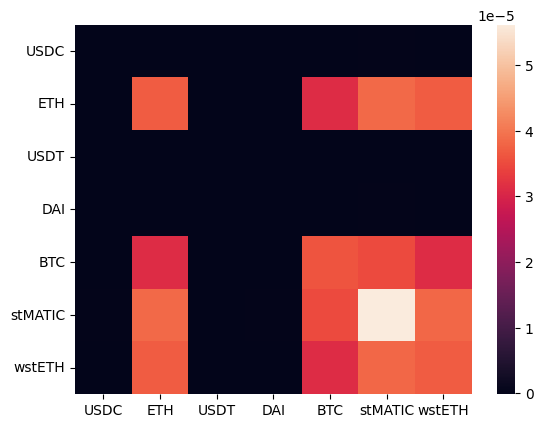

In [66]:
sns.heatmap(covariations, xticklabels=tokens, yticklabels=tokens)

In [67]:
n_samples = 10 ** 5

In [68]:
starting_values = np.array([prices[str(blocks[0])][token] for token in tokens]).reshape(-1, 1)

tokens

dict_keys(['USDC', 'ETH', 'USDT', 'DAI', 'BTC', 'stMATIC', 'wstETH'])

In [69]:
np.exp(np.cumsum(log_diff, axis=1)).min()

1257.2227020523667

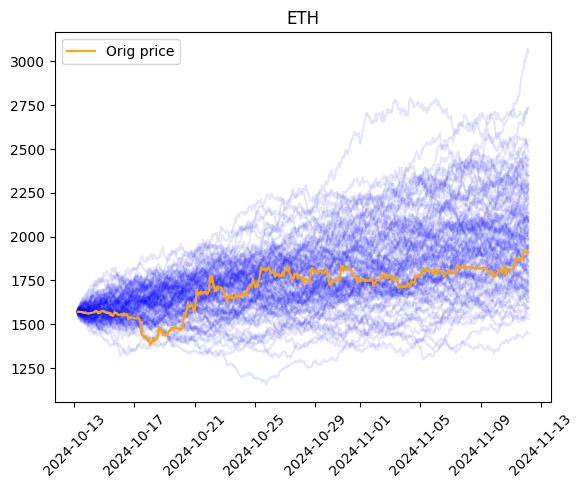

In [70]:
plt.title('ETH')
values = np.random.normal(means[1], np.sqrt(covariations[1][1]), size=(100, len(blocks) - 1))
starting_values = np.ones((100, 1)) * prices[str(blocks[0])][list(tokens)[1]]
log_diff = np.hstack([np.log(starting_values), values])
plt.plot(ts, np.exp(np.cumsum(log_diff, axis=1)).T, alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[1]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

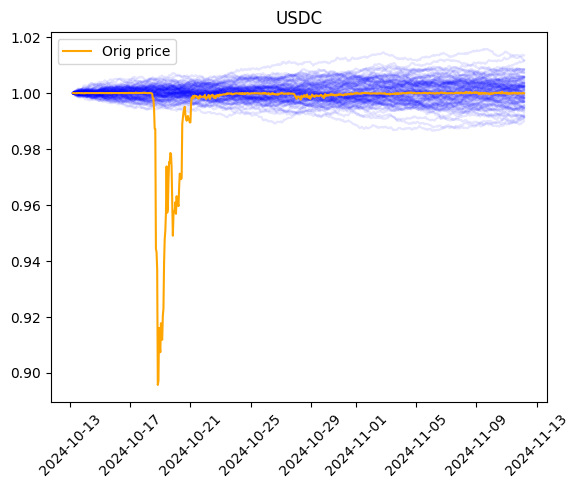

In [71]:
plt.title('USDC')
values = np.random.normal(means[0], np.sqrt(covariations[0][0]), size=(100, len(blocks) - 1))
starting_values = np.ones((100, 1)) * prices[str(blocks[0])][list(tokens)[0]]
log_diff = np.hstack([np.log(starting_values), values])
plt.plot(ts, np.exp(np.cumsum(log_diff, axis=1)).T, alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[0]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

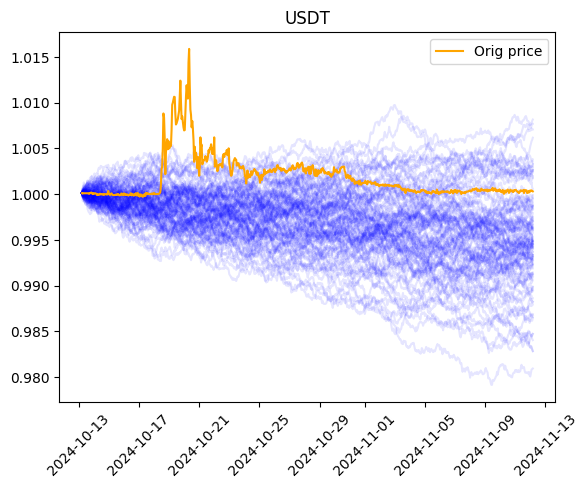

In [72]:
idx = 2
plt.title(list(tokens)[idx])
values = np.random.normal(means[idx], np.sqrt(covariations[idx][idx]), size=(100, len(blocks) - 1))
starting_values = np.ones((100, 1)) * prices[str(blocks[0])][list(tokens)[idx]]
log_diff = np.hstack([np.log(starting_values), values])
plt.plot(ts, np.exp(np.cumsum(log_diff, axis=1)).T, alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[idx]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

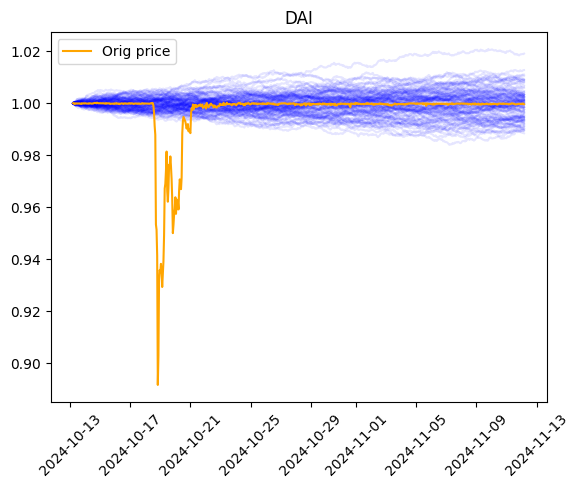

In [73]:
idx = 3
plt.title(list(tokens)[idx])
values = np.random.normal(means[idx], np.sqrt(covariations[idx][idx]), size=(100, len(blocks) - 1))
starting_values = np.ones((100, 1)) * prices[str(blocks[0])][list(tokens)[idx]]
log_diff = np.hstack([np.log(starting_values), values])
plt.plot(ts, np.exp(np.cumsum(log_diff, axis=1)).T, alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[idx]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

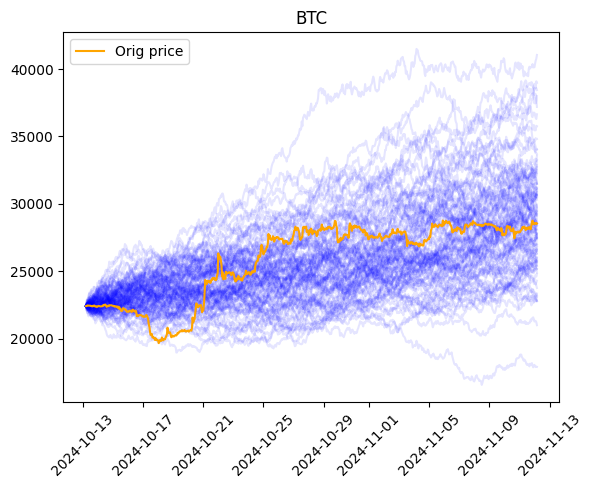

In [74]:
idx = 4
plt.title(list(tokens)[idx])
values = np.random.normal(means[idx], np.sqrt(covariations[idx][idx]), size=(100, len(blocks) - 1))
starting_values = np.ones((100, 1)) * prices[str(blocks[0])][list(tokens)[idx]]
log_diff = np.hstack([np.log(starting_values), values])
plt.plot(ts, np.exp(np.cumsum(log_diff, axis=1)).T, alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[idx]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

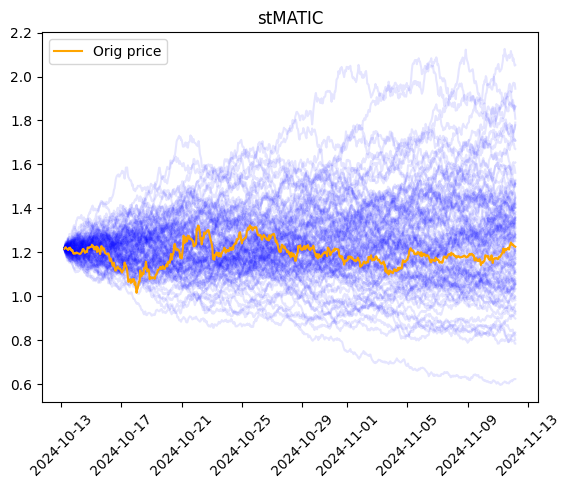

In [75]:
idx = 5
plt.title(list(tokens)[idx])
values = np.random.normal(means[idx], np.sqrt(covariations[idx][idx]), size=(100, len(blocks) - 1))
starting_values = np.ones((100, 1)) * prices[str(blocks[0])][list(tokens)[idx]]
log_diff = np.hstack([np.log(starting_values), values])
plt.plot(ts, np.exp(np.cumsum(log_diff, axis=1)).T, alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[idx]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

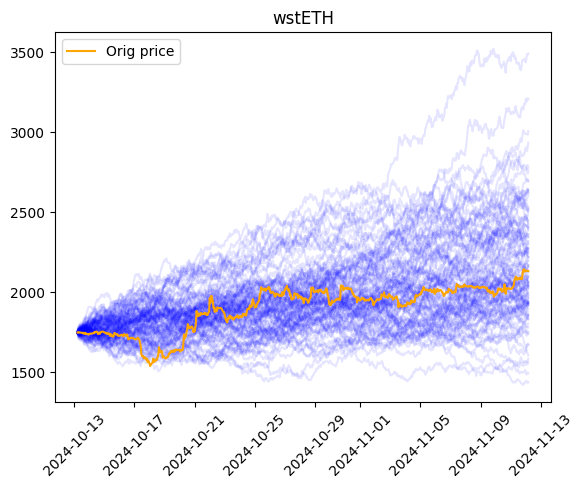

In [76]:
idx = 6
plt.title(list(tokens)[idx])
values = np.random.normal(means[idx], np.sqrt(covariations[idx][idx]), size=(100, len(blocks) - 1))
starting_values = np.ones((100, 1)) * prices[str(blocks[0])][list(tokens)[idx]]
log_diff = np.hstack([np.log(starting_values), values])
plt.plot(ts, np.exp(np.cumsum(log_diff, axis=1)).T, alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[idx]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);